<B> Презентация </B> <BR>
https://disk.yandex.ru/i/mKIlL_frW3NemQ

<I> Составлено: Дарьей Сясиной</I>

<I>Для: Продакт-менеджера приложения "Ненужные вещи"</I>

# Анализ поведения пользователей в мобильном приложении

## Цель:
- Улучшение приложения для увеличения вовлеченности пользователей

## Задачи:

1. Анализ связи между разными действиями пользователей и целевым событием — просмотром контактов. 
2. Оценка пользовательского поведения, особенно тех пользователей, которые просматривают контакты.
3. Оценка влияния введенных изменений (карты, добавление в избранное и др.).
4. Анализ эргономики приложения.
5. Анализ паттернов использования приложения пользователями
6. Исследовательский анализ данных

## Содержание <a id='content'></a>
   1. [Шаг 1. Загрузка и знакомство с данными](#intro)
   2. [Шаг 2. Предобработка данных](#prep)
   3. [Шаг 3. Исследовательский анализ данных (EDA)](#eda)
   4. [3.1 Выделение сессий использования приложения](#sessions)
   5. [3.2 Пользователи, которые смотрели целевую страницу](#goal_users)
   6. [3.3 Выделение когорт пользователей по времени](#cohort)
   7. [3.4 Анализ числа событий и пользователей](#events)
   8. [3.5 Конверсия](#conversion)
   9. [Шаг 4. Анализ бизнес-показателей](#analysis)
   10. [4.1 Расчет пользовательских метрик](#user_metrics)
   11. [4.2 Анализ связи между целевым и прочими действиями ](#goal_analysis)
   12. [4.3 Порядок событий в сессии](#order)
   13. [4.4 Промежутки времени до целевого события](#intervals)
   13. [Шаг 5. Проверка статистических гипотез](#hypothesis)
   14. [5.1 Гипотеза 1: конверсия в просмотры контактов различается у двух групп (по событиям)](#hypothesis1)
   15. [5.2 Гипотеза 2: конверсия в просмотры контактов различается у двух групп (по источникам)](#hypothesis2)
   16. [Шаг 6. Вывод](#conclusion)

### 1. Загрузка и знакомство с данными <a id="intro"></a>

Датасеты:

[mobile_dataset.csv](https://disk.yandex.ru/d/KaN8Wffo4Q510Q)

[mobile_sources.csv](https://disk.yandex.ru/d/RkfgQSEt-zD6Uw)

Загрузим нужные библиотеки и выгрузим данные

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();
from datetime import datetime, timedelta
import plotly.express as px
from plotly import graph_objects as go
import plotly.figure_factory as ff
from scipy import stats as st
import math as mth

In [ ]:
mobile_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [ ]:
mobile_dataset.info()
mobile_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

In [ ]:
mobile_sources.info()
mobile_sources.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

У нас два набора данных: 1) 74197 событий с их временем и совершившим пользователем; 2) 4293 пользователя и источник их прихода в приложение. <BR>
На первый взгляд пропусков в данных нет, из типов только объект. Приступим к предобработке.

### 2. Предобработка данных <a id="prep"></a>

<I>Проверка пропусков, дубликатов, оформления данных</I>

In [ ]:
print('Дубликаты в датасете по событиям:', mobile_dataset.duplicated().sum())
print('Дубликаты в датасете по источникам:', mobile_sources.duplicated().sum())

Дубликаты в датасете по событиям: 0
Дубликаты в датасете по источникам: 0


In [ ]:
print('Пропуски в датасете по событиям:', mobile_dataset.isnull().sum())
print('Пропуски в датасете по источникам:', mobile_sources.isnull().sum())

Пропуски в датасете по событиям: event.time    0
event.name    0
user.id       0
dtype: int64
Пропуски в датасете по источникам: userId    0
source    0
dtype: int64


Повезло, пропусков и дубликатов нет, так что приступим к работе с типами данных и стилем написания. Также добавим в первый датасет данные по источникам, сравнив, совпадают ли айди юзеров.

In [ ]:
mobile_sources.columns = ['user_id', 'source']
mobile_dataset.columns = ['event_time', 'event_name', 'user_id']

In [ ]:
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])

In [ ]:
if set(mobile_dataset['user_id'].unique()) == set(mobile_sources['user_id'].unique()):
    print('айди в датасетах совпадают')

айди в датасетах совпадают


In [ ]:
mobile_dataset = mobile_dataset.merge(mobile_sources, on='user_id')

In [ ]:
print('Первые данные:', mobile_dataset['event_time'].min())
print('Последние данные:', mobile_dataset['event_time'].max())
print('Рассматриваемый период:', mobile_dataset['event_time'].max() - mobile_dataset['event_time'].min())

Первые данные: 2019-10-07 00:00:00.431357
Последние данные: 2019-11-03 23:58:12.532487
Рассматриваемый период: 27 days 23:58:12.101130


Нам представлены данные с 7 октября по 3 ноября 2019 года, почти за 28 дней. Выделим даты и недели в отдельные столбцы

In [ ]:
mobile_dataset['event_week'] = mobile_dataset['event_time'].dt.isocalendar().week
mobile_dataset['event_date'] = mobile_dataset['event_time'].dt.date
mobile_dataset['event_dow'] = mobile_dataset['event_time'].dt.dayofweek

Посмотрим на уникальные значения и удалим неявные дубликаты.

In [ ]:
mobile_dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'tips_click', 'search_4',
       'search_2', 'search_5', 'contacts_show', 'search_6', 'photos_show',
       'search_1', 'search_3', 'favorites_add', 'contacts_call',
       'search_7', 'show_contacts'], dtype=object)

События 'contacts_show' и 'show_contacts' представляют собой одно и то же, а множество поисков ('search_1(2,3...)') для удобства работы в данном проекте объединим в одно действие.

In [ ]:
mobile_dataset.loc[mobile_dataset['event_name'] == 'show_contacts', 'event_name'] = 'contacts_show'

In [ ]:
sentence = mobile_dataset['event_name'].unique()
word = 'search'
for i in sentence:
    if word in i:
        mobile_dataset.loc[mobile_dataset['event_name'] == i, 'event_name'] = 'search'

In [ ]:
event_list = mobile_dataset['event_name'].unique()
event_list

array(['advert_open', 'tips_show', 'map', 'tips_click', 'search',
       'contacts_show', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

В процессе предобработки я проверила датасет на явные пропуски и дубликаты, которых не оказалось, зато оказались повторяющиеся названия событий, что было исправлено. Названия столбцов были приведены к общепринятому форматированию.
Также я выделила неделю и дату события в отдельные столбцы, что пригодится для когортного анализа и вычисления удержания. 

### 3. Исследовательский анализ данных <a id="eda"></a>

#### 3.1 Выделение сессий использования приложения <a id="sessions"></a>

Отсортируем данные по пользователю и посмотрим, сколько времени проходит между событиями одного пользователя. 

In [ ]:
mobile_dataset = mobile_dataset.sort_values(['user_id', 'event_time'])

In [ ]:
mobile_dataset['diff'] = mobile_dataset.groupby('user_id')['event_time'].diff(1)

In [ ]:
mobile_dataset['diff'].describe()

count                        69904
mean     0 days 03:53:01.169952121
std      1 days 01:32:57.259354294
min         0 days 00:00:00.000001
25%      0 days 00:00:23.594245250
50%         0 days 00:01:10.535313
75%      0 days 00:03:00.300498750
max        26 days 13:49:54.853516
Name: diff, dtype: object

Средняя разница между событиями - почти 4 часа, минимальная - 0 секунд, максимальная - 26 дней. Медианная разница - 1 час, при этом, четверть событий разделены с ближайшими промежутком в менее чем 24 минуты, а 75% укладываются в промежуток в 3 часа. 1 час кажется слишком длительным перерывом для сессии, возьмем в качестве промежутка между сессиями время в 30 минут. 

In [ ]:
condition = (mobile_dataset.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()
#создадим счетчик для групп по условию
mobile_dataset['session_id'] = mobile_dataset.groupby(['user_id', condition], sort=False).ngroup() + 1
mobile_dataset

event_time     event_name  \
2171  2019-10-07 13:39:45.989359      tips_show   
2172  2019-10-07 13:40:31.052909      tips_show   
2173  2019-10-07 13:41:05.722489      tips_show   
2174  2019-10-07 13:43:20.735461      tips_show   
2175  2019-10-07 13:45:30.917502      tips_show   
...                          ...            ...   
19048 2019-11-03 15:51:23.959572      tips_show   
19049 2019-11-03 15:51:57.899997  contacts_show   
19050 2019-11-03 16:07:40.932077      tips_show   
19051 2019-11-03 16:08:18.202734      tips_show   
19052 2019-11-03 16:08:25.388712      tips_show   

                                    user_id  source  event_week  event_date  \
2171   0001b1d5-b74a-4cbf-aeb0-7df5947bf349   other          41  2019-10-07   
2172   0001b1d5-b74a-4cbf-aeb0-7df5947bf349   other          41  2019-10-07   
2173   0001b1d5-b74a-4cbf-aeb0-7df5947bf349   other          41  2019-10-07   
2174   0001b1d5-b74a-4cbf-aeb0-7df5947bf349   other          41  2019-10-07   
2175   0001b1d5-b74a-4cbf-aeb0-7df5947bf349   other          41  2019-10-07   
...                                     ...     ...         ...         ...   
19048  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  google          44  2019-11-03   
19049  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  google          44  2019-11-03   
19050  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  google          44  2019-11-03   
19051  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  google          44  2019-11-03   
19052  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  google          44  2019-11-03   

       event_dow                   diff  session_id  
2171           0                    NaT           1  
2172           0 0 days 00:00:45.063550           1  
2173           0 0 days 00:00:34.669580           1  
2174           0 0 days 00:02:15.012972           1  
2175           0 0 days 00:02:10.182041           1  
...          ...                    ...         ...  
19048          6 0 days 00:00:27.886483       10368  
19049          6 0 days 00:00:33.940425       10368  
19050          6 0 days 00:15:43.032080       10368  
19051          6 0 days 00:00:37.270657       10368  
19052          6 0 days 00:00:07.185978       10368  

[74197 rows x 9 columns]

In [ ]:
mobile_dataset.groupby('session_id').agg({'event_time':'nunique', 'event_name':'nunique'}).describe()

event_time    event_name
count  10368.000000  10368.000000
mean       7.156346      1.722029
std        9.581106      0.893418
min        1.000000      1.000000
25%        2.000000      1.000000
50%        4.000000      1.000000
75%        9.000000      2.000000
max      149.000000      6.000000

У нас получилось 10368 сессий. В среднем за сессию происходит 4-7 событий, но многие повторяются, так как уникальных типов событий в среднем 1,5-2 на сессию. Посчитаем также, сколько времени длится каждая сессия.

In [ ]:
mobile_dataset['time_spent'] = mobile_dataset.groupby(['session_id'])['event_time'].diff(1)
mobile_dataset['time_spent'] = mobile_dataset.groupby(['session_id'])['time_spent'].shift(-1)
mobile_dataset['time_spent'] = mobile_dataset['time_spent'] / np.timedelta64(1, 's')

In [ ]:
mobile_dataset['time_spent'].describe()

count    63829.000000
mean       125.508308
std        208.693766
min          0.000001
25%         20.152663
50%         60.916218
75%        135.597551
max       1799.910144
Name: time_spent, dtype: float64

Логично, что наибольшая сессия длится почти 30 минут, а наименьшая - чуть больше 0 секунд, но нам могут пригодиться сведения, что средняя продолжительность сессии - чуть дольше 2 минут, медианная - 1 минута, и только четверть сессий длится дольше 135 секунд. 

Выделим в отдельный датасет данные по событиям, с которых начинается сессия, чтобы использовать их в дальнейшем.

In [ ]:
sessions_start_df = mobile_dataset[(mobile_dataset['diff'].isnull()) | (mobile_dataset['diff'] > '1800 seconds')]
sessions_start_df.head(5)

event_time event_name  \
2171  2019-10-07 13:39:45.989359  tips_show   
2180  2019-10-09 18:33:55.577963        map   
2184  2019-10-21 19:52:30.778932  tips_show   
2198  2019-10-22 11:18:14.635436        map   
42960 2019-10-19 21:34:33.849769     search   

                                    user_id  source  event_week  event_date  \
2171   0001b1d5-b74a-4cbf-aeb0-7df5947bf349   other          41  2019-10-07   
2180   0001b1d5-b74a-4cbf-aeb0-7df5947bf349   other          41  2019-10-09   
2184   0001b1d5-b74a-4cbf-aeb0-7df5947bf349   other          43  2019-10-21   
2198   0001b1d5-b74a-4cbf-aeb0-7df5947bf349   other          43  2019-10-22   
42960  00157779-810c-4498-9e05-a1e9e3cedf93  yandex          42  2019-10-19   

       event_dow                    diff  session_id  time_spent  
2171           0                     NaT           1   45.063550  
2180           2  2 days 04:44:13.861346           2   92.683012  
2184           0 12 days 01:10:07.814984           3   46.386077  
2198           1  0 days 15:10:44.584408           4   55.894026  
42960          5                     NaT           5   45.446830

#### 3.2 Пользователи, которые смотрели целевую страницу <a id="goal_users"></a>

Выделим в отдельный датасет данные по тем пользователям, которые просматривали страницу с контактами.

In [ ]:
goal_users = mobile_dataset.query("event_name == 'contacts_show'")['user_id']
mobile_dataset['goal_user'] = mobile_dataset['user_id'].isin(goal_users)

In [ ]:
print('Всего просмотров контактов:', len(goal_users))

Всего просмотров контактов: 4529


In [ ]:
print('Уникальных пользователей, смотревших контакты:', goal_users.nunique())

Уникальных пользователей, смотревших контакты: 981


Значит, на каждого юзера приходится около 4-5 просмотров.

In [ ]:
goal_users_df = mobile_dataset[mobile_dataset['goal_user'] == True]
goal_users_df.head(5)

event_time   event_name  \
42960 2019-10-19 21:34:33.849769       search   
42961 2019-10-19 21:35:19.296599       search   
42962 2019-10-19 21:36:44.344691       search   
42963 2019-10-19 21:40:38.990477  photos_show   
42964 2019-10-19 21:42:13.837523  photos_show   

                                    user_id  source  event_week  event_date  \
42960  00157779-810c-4498-9e05-a1e9e3cedf93  yandex          42  2019-10-19   
42961  00157779-810c-4498-9e05-a1e9e3cedf93  yandex          42  2019-10-19   
42962  00157779-810c-4498-9e05-a1e9e3cedf93  yandex          42  2019-10-19   
42963  00157779-810c-4498-9e05-a1e9e3cedf93  yandex          42  2019-10-19   
42964  00157779-810c-4498-9e05-a1e9e3cedf93  yandex          42  2019-10-19   

       event_dow                   diff  session_id  time_spent  goal_user  
42960          5                    NaT           5   45.446830       True  
42961          5 0 days 00:00:45.446830           5   85.048092       True  
42962          5 0 days 00:01:25.048092           5  234.645786       True  
42963          5 0 days 00:03:54.645786           5   94.847046       True  
42964          5 0 days 00:01:34.847046           5  161.752208       True

Мы получили отдельный датафрейм с данными по всем событиям пользователей, которые просматривали контакты, - всего получилось 27197 событий. Сравним их с показателями по датасету в целом.

In [ ]:
pd.concat([goal_users_df['source'].value_counts(), 
                goal_users_df['source'].value_counts(normalize=True).mul(100)],axis=1, keys=('quantity','% of total'))

quantity  % of total
yandex     12499   45.957275
google      8513   31.301246
other       6185   22.741479

In [ ]:
pd.concat([mobile_dataset['source'].value_counts(), 
                mobile_dataset['source'].value_counts(normalize=True).mul(100)],axis=1, keys=('quantity','% of total'))

quantity  % of total
yandex     34286   46.209415
google     20445   27.555022
other      19466   26.235562

In [ ]:
pd.concat([goal_users_df['event_name'].value_counts(), 
                goal_users_df['event_name'].value_counts(normalize=True).mul(100)],axis=1, keys=('quantity','% of total'))

quantity  % of total
tips_show         12768   46.946354
contacts_show      4529   16.652572
photos_show        3828   14.075082
search             2084    7.662610
advert_open        1589    5.842556
map                1101    4.048241
contacts_call       541    1.989190
favorites_add       424    1.558995
tips_click          333    1.224400

In [ ]:
pd.concat([mobile_dataset['event_name'].value_counts(), 
                mobile_dataset['event_name'].value_counts(normalize=True).mul(100)],axis=1, keys=('quantity','% of total'))

quantity  % of total
tips_show         40055   53.984662
photos_show       10012   13.493807
search             6784    9.143227
advert_open        6164    8.307614
contacts_show      4529    6.104020
map                3881    5.230670
favorites_add      1417    1.909781
tips_click          814    1.097079
contacts_call       541    0.729140

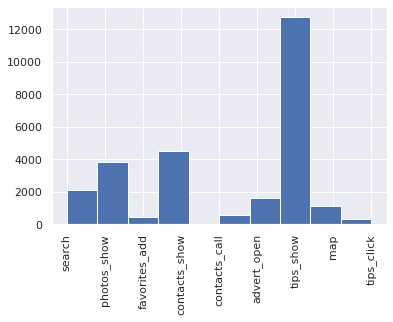

In [ ]:
plt.hist(goal_users_df['event_name'])
plt.xticks(rotation='vertical')
plt.show()

Помимо контактов, эти пользователи чаще всего смотрели страницу с фото, поиск, страницу объявления, карту и прочее. Также такие пользователи чуть чаще смотрят фото, чем в целом по датасету. Самое популярное событие - показ рекомендованного - не является самостоятельным действием пользователя, оно происходит автоматически, поэтому в некоторых дальнейших расчетах его можно будет исключить.

In [ ]:
print('В среднем на каждого пользователя, совершавшего целевое действие, приходится по {:0.2f} событий.'.format(goal_users_df.groupby('user_id')['event_time'].count().mean()))

В среднем на каждого пользователя, совершавшего целевое действие, приходится по 27.72 событий.


In [ ]:
print('В среднем на каждого пользователя, совершавшего целевое действие, приходится по {:0.2f} сессий.'.format(goal_users_df.groupby('user_id')['session_id'].nunique().mean()))

В среднем на каждого пользователя, совершавшего целевое действие, приходится по 3.89 сессий.


In [ ]:
print('В среднем на каждого пользователя приходится по {:0.2f} событий.'.format(mobile_dataset.groupby('user_id')['event_time'].count().mean()))

В среднем на каждого пользователя приходится по 17.28 событий.


In [ ]:
print('В среднем на каждого пользователя приходится по {:0.2f} сессий.'.format(mobile_dataset.groupby('user_id')['session_id'].nunique().mean()))

В среднем на каждого пользователя приходится по 2.42 сессий.


Пользователи, совершавшие целевое действие, в целом совершали больше событий и больше сессий. <BR>
  Выведем самых активных пользователей приложения.

In [ ]:
goal_users_df.groupby('user_id')['event_name'].describe().sort_values(by='count', ascending=False).head(10)

count unique          top freq
user_id                                                            
cb36854f-570a-41f4-baa8-36680b396370   478      4    tips_show  317
e13f9f32-7ae3-4204-8d60-898db040bcfc   465      7  photos_show  177
21230dd9-2f7f-4b77-a436-43d4d10388e0   400      5    tips_show  346
be1449f6-ca45-4f94-93a7-ea4b079b8f0f   397      4    tips_show  217
e38cb669-7335-4d56-9de5-c8d5d2f13fd3   362      7    tips_show  195
abdcbe3c-221b-4f59-afd9-bf9ca78f7e4c   356      4    tips_show  265
320cab3c-e823-4dff-8c01-c4253764640a   353      5    tips_show  191
28fccdf4-7b9e-42f5-bc73-439a265f20e9   308      5    tips_show  294
fffb9e79-b927-4dbb-9b48-7fd09b23a62b   303      3    tips_show  233
c140f88a-c544-4ce6-a6bd-578a1a0d1b18   288      4    tips_show  239

Самые активные пользователи совершают до 478 действий, но большинство из них повторяются, в среднем у них 4-5 типов событий. Самые популярные - автоматический показ рекомендаций, а также просмотр фото.

#### 3.3 Выделение когорт пользователей по времени <a id="cohort"></a>

Для когортного анализа нам нужно разделить пользователей на когорты в зависимости от недели их присоединения к приложению. Сначала задаем функцию для создания отдельного датафрейма с айди пользователя и временем его первого и последнего действия.

In [ ]:
# функция для создания пользовательских профилей

def get_profiles(data):

    # находим параметры первых посещений
    profiles = (
        data.sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg(
            {
                'event_time': ['first', 'last'],
                'source': 'first',
                'event_name': 'first',
                'event_week':'first',
                'goal_user': 'first'
            }
        )
        .reset_index()
        .set_axis(['user_id', 'first_ts', 'last_ts', 'source', 'event_name', 'first_week', 'goal_user'], axis='columns', inplace=False)
        
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['first_visit'] = profiles['first_ts'].dt.date
    profiles['last_visit'] = profiles['last_ts'].dt.date


            

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    cohort_users = (profiles.groupby('first_visit').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'unique_users'}).reset_index())
    cohort_week_users = (profiles.groupby('first_week').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'unique_users'}).reset_index())

    return profiles, cohort_users, cohort_week_users


In [ ]:
profiles, cohort_users, cohort_week_users = get_profiles(mobile_dataset)
profiles

user_id                   first_ts  \
0     0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-07 13:39:45.989359   
1     00157779-810c-4498-9e05-a1e9e3cedf93 2019-10-19 21:34:33.849769   
2     00463033-5717-4bf1-91b4-09183923b9df 2019-11-01 13:54:35.385028   
3     004690c3-5a84-4bb7-a8af-e0c8f8fca64e 2019-10-18 22:14:05.555052   
4     00551e79-152e-4441-9cf7-565d7eb04090 2019-10-25 16:44:41.263364   
...                                    ...                        ...   
4288  ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07 2019-10-13 16:11:27.414960   
4289  ffc01466-fdb1-4460-ae94-e800f52eb136 2019-10-07 20:32:49.997044   
4290  ffcf50d9-293c-4254-8243-4890b030b238 2019-10-23 11:51:35.199237   
4291  ffe68f10-e48e-470e-be9b-eeb93128ff1a 2019-10-21 16:39:33.867145   
4292  fffb9e79-b927-4dbb-9b48-7fd09b23a62b 2019-10-12 00:57:21.241896   

                        last_ts  source     event_name  first_week  goal_user  \
0    2019-10-22 11:30:52.807203   other      tips_show          41      False   
1    2019-11-03 17:12:09.708771  yandex         search          42       True   
2    2019-11-01 14:19:17.860053  yandex    photos_show          44      False   
3    2019-10-31 21:42:15.606558  google         search          42      False   
4    2019-10-29 02:17:12.342406  yandex  contacts_show          43       True   
...                         ...     ...            ...         ...        ...   
4288 2019-10-26 19:53:51.993545  yandex            map          41      False   
4289 2019-10-07 20:33:42.135500  yandex    photos_show          41       True   
4290 2019-10-23 11:52:55.577369  google      tips_show          43      False   
4291 2019-10-28 07:17:52.646652  yandex         search          43       True   
4292 2019-11-03 16:08:25.388712  google      tips_show          41       True   

     first_visit  last_visit  
0     2019-10-07  2019-10-22  
1     2019-10-19  2019-11-03  
2     2019-11-01  2019-11-01  
3     2019-10-18  2019-10-31  
4     2019-10-25  2019-10-29  
...          ...         ...  
4288  2019-10-13  2019-10-26  
4289  2019-10-07  2019-10-07  
4290  2019-10-23  2019-10-23  
4291  2019-10-21  2019-10-28  
4292  2019-10-12  2019-11-03  

[4293 rows x 9 columns]

In [ ]:
cohort_week_users

first_week  unique_users
0          41          1130
1          42          1166
2          43          1094
3          44           903

У нас получилось 4 когорты пользователей по 4 неделям с примерно одинаковым распределением пользователей, только в последней когорте их меньше - на 150-200 человек.

#### 3.4 Анализ числа событий и пользователей <a id="events"></a>

Посмотрим еще раз, какое событие чаще всего совершается в приложении.

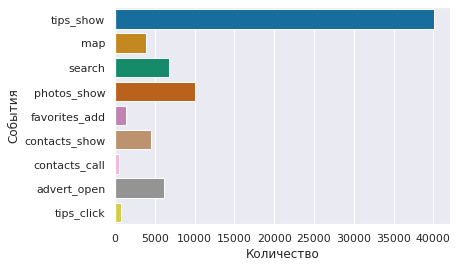

In [ ]:
sns.set_style('darkgrid')
sns.countplot(y='event_name',data=mobile_dataset,palette='colorblind')
plt.xlabel("Количество")
plt.ylabel("События")
plt.show() 

Чаще всего повторяется автоматический показ рекомендаций, затем идут просмотр фото (скорее всего, в объявлении их сразу несколько штук), поиск и открытие объявление. <BR>
Также посчитаем количество событий и пользователей на каждом шаге, а также отдельно повторим расчет только для пользователей, дошедших до просмотра контактов.

In [ ]:
event_count_plot = mobile_dataset.query('event_name !="tips_show"')\
              .groupby('event_name').agg({'user_id': ['count', 'nunique']})\
              .sort_values(by=('user_id', 'count'), ascending=False)
event_count_plot.columns = ['Число событий', 'Число пользователей']
event_count_plot

Число событий  Число пользователей
event_name                                       
photos_show            10012                 1095
search                  6784                 1666
advert_open             6164                  751
contacts_show           4529                  981
map                     3881                 1456
favorites_add           1417                  351
tips_click               814                  322
contacts_call            541                  213

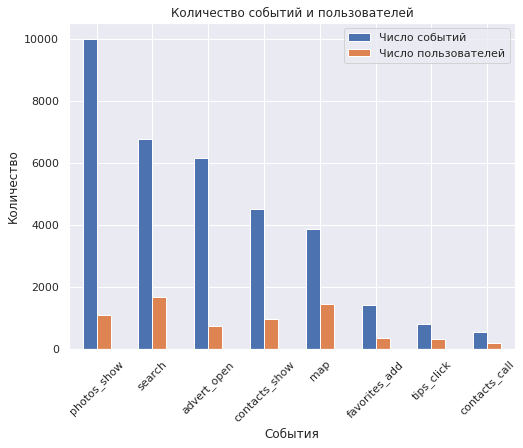

In [ ]:
ax = event_count_plot.plot(kind='bar', figsize=(8, 6), title='Количество событий и пользователей', xlabel='События', ylabel='Количество', rot=45)
plt.show()

Не учитывая просмотр рекомендованных объявлений, самые популярные события - просмотр фото, поиск, открытие объявления, просмотр контактов. Что касается числа совершающих эти действия юзеров, вперед выходят поиск и просмотр карты. Вероятно, из-за того, что одни и те же пользователи несколько раз повторяют самые популярные действия.

In [ ]:
event_goal_plot = mobile_dataset.query('goal_user == True and event_name !="tips_show"')\
              .groupby('event_name').agg({'user_id': ['count', 'nunique']})\
              .sort_values(by=('user_id', 'count'), ascending=False)
event_goal_plot.columns = ['Число событий', 'Число пользователей']
event_goal_plot

Число событий  Число пользователей
event_name                                       
contacts_show           4529                  981
photos_show             3828                  339
search                  2084                  377
advert_open             1589                  138
map                     1101                  289
contacts_call            541                  213
favorites_add            424                  136
tips_click               333                  100

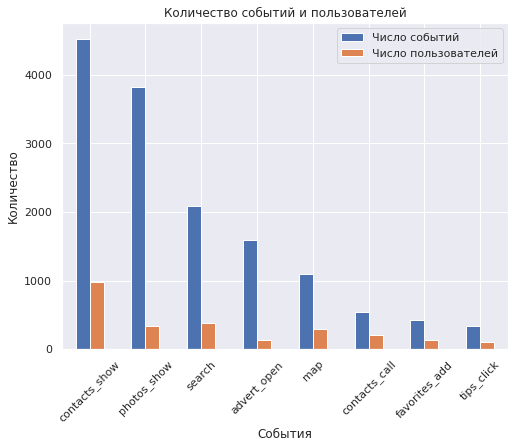

In [ ]:
ax = event_goal_plot.plot(kind='bar', figsize=(8, 6), title='Количество событий и пользователей', xlabel='События', ylabel='Количество', rot=45)
plt.show()

Если же отдельно смотреть сессии только тех пользователей, которые когда-либо просматривали контакты, то мы увидим большое число просмотра контактов и просмотра фото, но эти цифры в разрезе числа уникальных пользователей значительно ниже. Видимо, смотрящие контакты пользователи также смотрят много фотографий.

Также рассмотрим отдельно события, с которых начинаются сессии пользователей.

In [ ]:
sessions_start_df['event_name'].value_counts()

tips_show        3806
search           2499
photos_show      1673
map              1288
contacts_show     543
advert_open       407
favorites_add     107
tips_click         45
Name: event_name, dtype: int64

In [ ]:
event_start_plot = sessions_start_df.query('event_name !="tips_show"')\
              .groupby('event_name').agg({'user_id': ['count', 'nunique']})\
              .sort_values(by=('user_id', 'count'), ascending=False)
event_start_plot.columns = ['Число событий', 'Число пользователей']
event_start_plot

Число событий  Число пользователей
event_name                                       
search                  2499                 1402
photos_show             1673                  721
map                     1288                  966
contacts_show            543                  375
advert_open              407                  248
favorites_add            107                   93
tips_click                45                   35

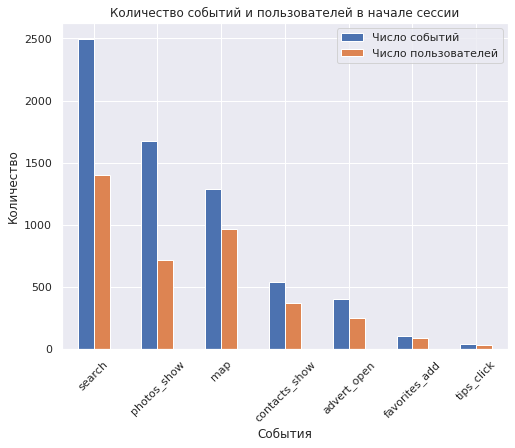

In [ ]:
ax = event_start_plot.plot(kind='bar', figsize=(8, 6), title='Количество событий и пользователей в начале сессии', xlabel='События', ylabel='Количество', rot=45)
plt.show()

Что касается событий, с которых начинаются сессии пользователей, то чаще всего это поиск, просмотр фото и карт. Некоторые пользователи сразу смотрят контакты, возможно, это действия, которые прошли после обозначенного нами перерыва между сессиями и они скорее являются продолжением предыдущего процесса.

Посмотрим на динамику числа уникальных юзеров в течение времени исследования в разрезе событий.

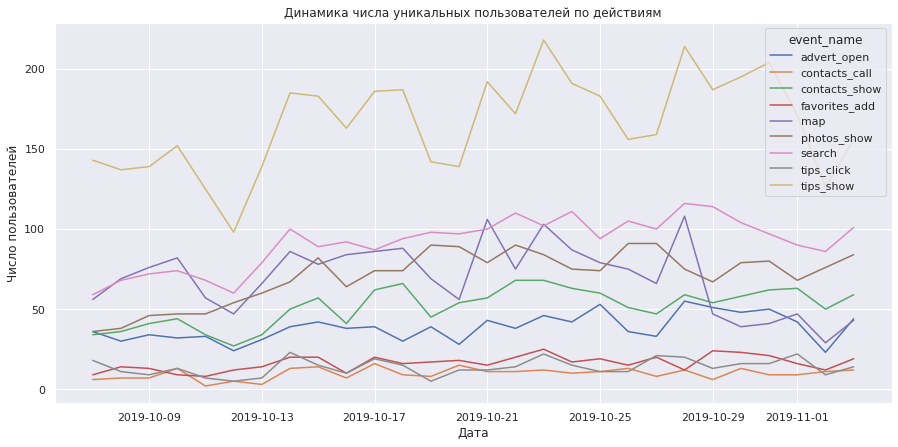

In [ ]:
users_pivot = mobile_dataset.pivot_table(
    index='event_date', columns='event_name', values='user_id', aggfunc='nunique'
)
users_pivot.plot(grid=True, figsize=(15, 7))
plt.ylabel('Число пользователей')
plt.xlabel('Дата')
plt.title('Динамика числа уникальных пользователей по действиям')
plt.show()

Помимо автоматических рекомендаций, в топе события по поиску, показу фото и показу контактов. Динамика взаимодействий с картой скачкообразная, и к концу периода ее активность снижается. Также мы видим периодические падения и пики активности, похоже, связанные с выходными и будними днями - в выходные активность падает, в понедельник повышается.

In [ ]:
users_pivot.mean().sort_values(ascending=False)

event_name
tips_show        165.785714
search            91.678571
photos_show       70.750000
map               69.464286
contacts_show     51.571429
advert_open       38.535714
favorites_add     16.357143
tips_click        13.750000
contacts_call      9.750000
dtype: float64

В среднем, в сутки 50 пользователей открывают контакты, а звонят по ним 9-10 человек. Зато 165 человек видят рекомендуемое, а кликают по нему только 13. 

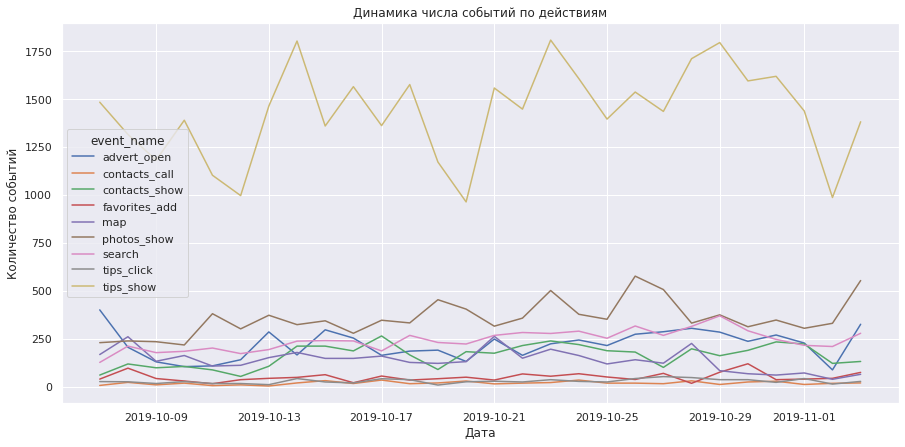

In [ ]:
events_pivot = mobile_dataset.pivot_table(
    index='event_date', columns='event_name', values='event_time', aggfunc='count'
)
events_pivot.plot(grid=True, figsize=(15, 7))
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.title('Динамика числа событий по действиям')
plt.show()

Если же смотреть на динамику в разрезе количества событий, то вперед выходят показы фото, значит, данная фича востребована. Число действий с просмотром карт снижается к концу рассматриваемого периода. А взаимодействий с добавлением в избранное, звонками по контактам и кликам по рекомендациям довольно мало на протяжении всего срока исследования.

In [ ]:
events_pivot.mean().sort_values(ascending=False)

event_name
tips_show        1430.535714
photos_show       357.571429
search            242.285714
advert_open       220.142857
contacts_show     161.750000
map               138.607143
favorites_add      50.607143
tips_click         29.071429
contacts_call      19.321429
dtype: float64

Рекомендации показываются в среднем 1430 раз в сутки, фото смотрят 350 раз, а карту - 138, контакты просматривают 161 раз.

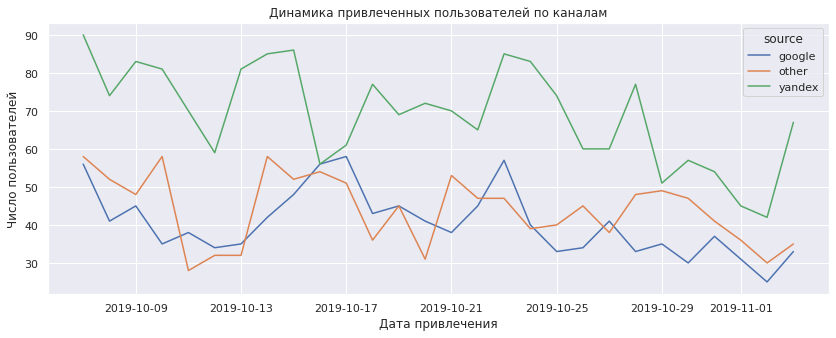

In [ ]:
channels_pivot = profiles.pivot_table(
    index='first_visit', columns='source', values='user_id', aggfunc='nunique'
)
channels_pivot.plot(grid=True, figsize=(14, 5))
plt.ylabel('Число пользователей')
plt.xlabel('Дата привлечения')
plt.title('Динамика привлеченных пользователей по каналам')
plt.show()

Число привлеченных через Яндекс пользователей значительно превышает другие источники, и хотя наблюдаются некоторые спады (12 и 16 октября, 2 ноября), этот канал все же лидирует.

Помимо общего числа событий и пользователей, нам важна их результативность - конверсия в целевое событие - просмотр контактов.

#### 3.5 Конверсия <a id="conversion"></a>

Создадим функцию для подсчета конверсии - для этого нам нужно общее число (событий или юзеров) и число целевых. Сохраним в датафрейм данные с общим числом пользователей/событий по всем типам, а также посмотрим, какая их часть дошла до просмотра контактов. 

In [ ]:
def conversion_calc(data, i_list, column_name, unit):
    types = []
    totals = []
    values = []
    conversion = []
    for i in i_list:
        types.append(i)
        total_stuff = data.loc[data[column_name] == i][unit].nunique()
        totals.append(total_stuff)
        valued_stuff = data.loc[(data[column_name] == i)&(data['goal_user'] == True)][unit].nunique()
        values.append(valued_stuff)
        conversion_value = (valued_stuff / total_stuff) *100
        conversion.append(conversion_value)
    conversion_df = pd.DataFrame({'type':types, 'total': totals, 'valued': values, 'conversion':conversion})
    return conversion_df.sort_values(by='conversion', ascending=False)

Посчитаем конверсию в просмотры по пользователям и по событиям в разрезе событий

In [ ]:
conversion_calc(mobile_dataset, event_list, 'event_name', 'user_id')

type  total  valued  conversion
5  contacts_show    981     981  100.000000
8  contacts_call    213     213  100.000000
7  favorites_add    351     136   38.746439
3     tips_click    322     100   31.055901
6    photos_show   1095     339   30.958904
4         search   1666     377   22.629052
2            map   1456     289   19.848901
1      tips_show   2801     516   18.421992
0    advert_open    751     138   18.375499

In [ ]:
conversion_calc(mobile_dataset, event_list, 'event_name', 'event_time')

type  total  valued  conversion
5  contacts_show   4529    4529  100.000000
8  contacts_call    541     541  100.000000
3     tips_click    814     333   40.909091
6    photos_show  10012    3828   38.234119
1      tips_show  40055   12768   31.876170
4         search   6784    2084   30.719340
7  favorites_add   1417     424   29.922371
2            map   3881    1101   28.368977
0    advert_open   6164    1589   25.778715

Несмотря на низкое число взаимодействий с добавлением в избранное, у этого действия довольно высокая конверсия в разрезе уникальных пользователей. Также результативны просмотры рекомендаций и просмотр фото. Значит, и эти фичи полезны для приложения.

Посчитаем конверсию в просмотры по пользователям и по событиям в разрезе источников пользователей.

In [ ]:
sources = mobile_dataset['source'].unique()
sources

array(['other', 'yandex', 'google'], dtype=object)

In [ ]:
conversion_calc(mobile_dataset, sources, 'source', 'user_id')

type  total  valued  conversion
1  yandex   1934     478   24.715615
2  google   1129     275   24.357839
0   other   1230     228   18.536585

In [ ]:
conversion_calc(mobile_dataset, sources, 'source', 'event_time')

type  total  valued  conversion
2  google  20445    8513   41.638542
1  yandex  34286   12499   36.455113
0   other  19466    6185   31.773348

Как мы видим, конверсия у пользователей, пришедших в приложение через яндекс, примерно равна с пользователями через гугл. А в разрезе количества событий юзеры, которых привел гугл, выходят вперед, значит, им нужно меньше действий для перехода к просмотру контактов. Органический трафик, естественно, наименее результативный.

Посмотрим также конверсию в разные дни недели.

In [ ]:
event_dows = mobile_dataset['event_dow'].unique()

In [ ]:
conversion_calc(mobile_dataset, event_dows, 'event_dow', 'user_id')

type  total  valued  conversion
6     4    976     316   32.377049
5     3   1074     333   31.005587
3     5    873     258   29.553265
1     2   1058     304   28.733459
4     6    975     277   28.410256
2     1   1032     293   28.391473
0     0   1060     299   28.207547

In [ ]:
conversion_calc(mobile_dataset, event_dows, 'event_dow', 'event_time')

type  total  valued  conversion
6     4   9969    4101   41.137526
5     3  10762    4318   40.122654
2     1  11145    4095   36.742934
3     5   9154    3355   36.650645
1     2  10995    3914   35.597999
4     6  10501    3616   34.434816
0     0  11671    3798   32.542199

Результативнее всего четверги и пятницы, а в понедельник и воскресенье люди не часто доходят до просмотра контактов.

Рассмотрев число и конверсию разных событий, отмечено, что несмотря на высокое количество как пользователей, выполнявших события, так и самих событий просмотра фото, поиска и т.д., и незначительное число взаимодействий с избранным и рекомендациями, уникальные пользователи, совершавшие "непопулярные действия", чаще переходят к просмотру контактов.

### 4. Анализ бизнес-показателей <a id="analysis"></a>

#### 4.1 Расчет пользовательских метрик - DAU, WAU, Retention rate <a id="user_metrics"></a>

In [ ]:
dau_total = (
    mobile_dataset.groupby('event_date').agg({'user_id': 'nunique'}).mean()
)

wau_total = (
    mobile_dataset.groupby(['event_week'])
    .agg({'user_id': 'nunique'})
    .mean()
)

print('Количество активных пользователей в день (DAU):', int(dau_total))
print('Количество активных пользователей в неделю (WAU):', int(wau_total))
print(dau_total / wau_total * 100)

Количество активных пользователей в день (DAU): 279
Количество активных пользователей в неделю (WAU): 1382
user_id    20.193748
dtype: float64


Рассмотрим удержание по дням и неделям, для чего зададим функцию.

In [ ]:
dims1 = 'first_visit'
dims2 = 'first_week'

In [ ]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dims,
    ignore_horizon=False,
    
):
        # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    matching_profiles = profiles.query('first_visit <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    matching_profiles = matching_profiles.merge(
        mobile_dataset[['user_id', 'event_time']], on='user_id', how='left'
    )
    matching_profiles['lifetime'] = (
        matching_profiles['event_time'] - matching_profiles['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(data, horizon_days):
        result = data.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            data.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(matching_profiles, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        matching_profiles, horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return matching_profiles, result_grouped, result_in_time

In [ ]:
observation_date = datetime(2019, 11, 4).date()  # момент анализа - следующий за рассматриваемым периодом день
horizon_days = 7
retention_raw1, retention_grouped1, retention_history1 = get_retention(
    profiles, mobile_dataset, observation_date, horizon_days, dims1
)

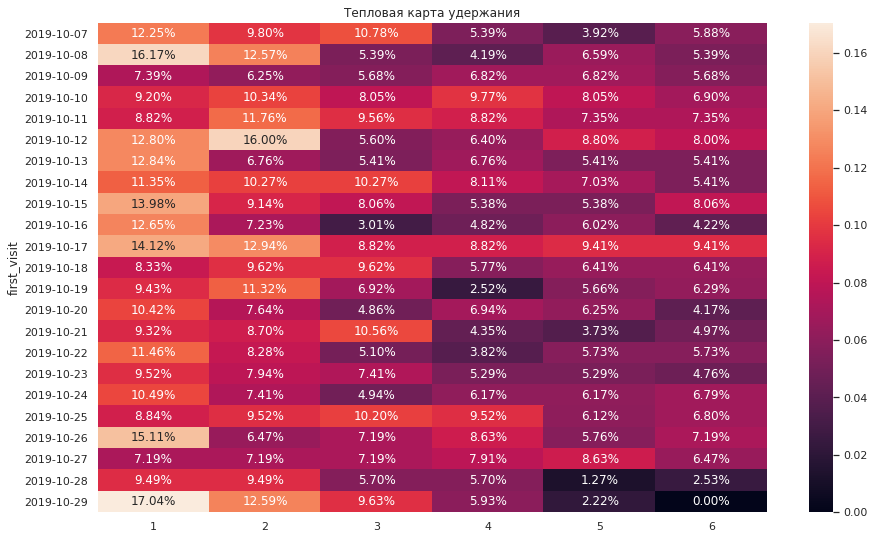

In [ ]:
plt.figure(figsize=(15, 9))  # задаём размер графика
sns.heatmap(
    retention_grouped1.drop(columns=['cohort_size', 0]),  # удаляем размеры когорт
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.show()

Удержание для приложения довольно низкое, и со временем становится ниже. Рассматриваемый период довольно короткий, так что это снижение нельзя назвать фундаментальным, но на него стоит обратить внимание.

In [ ]:
observation_date = datetime(2019, 11, 4).date()  # момент анализа
horizon_days = 7
retention_raw2, retention_grouped2, retention_history2 = get_retention(
    profiles, mobile_dataset, observation_date, horizon_days, dims2
)


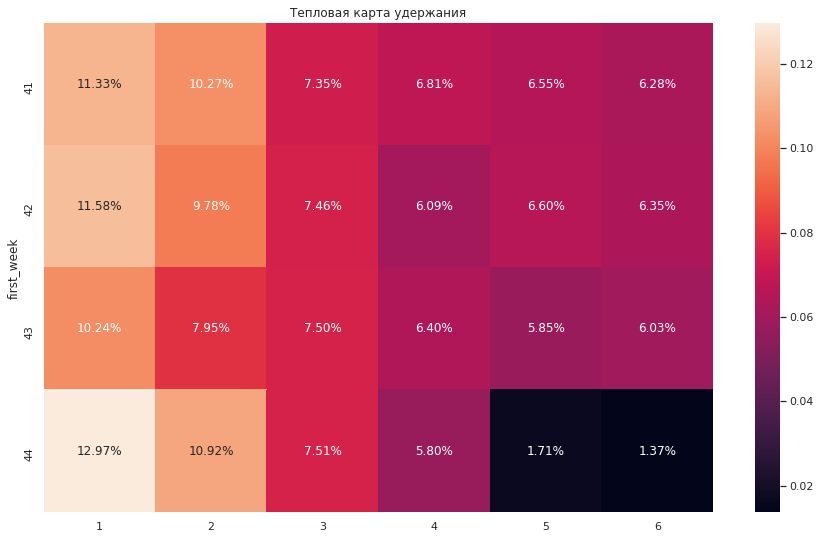

In [ ]:
plt.figure(figsize=(15, 9))  # задаём размер графика
sns.heatmap(
    retention_grouped2.drop(columns=['cohort_size', 0]),  # удаляем размеры когорт
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.show()

Удержание пользователей по неделям тоже выглядит не особо высоким. Возможно, стоит обратить на это внимание и поработать над его повышением.

#### 4.2 Анализ связи между целевым и прочими действиями пользователя  <a id="goal_analysis"></a>

Проанализируем действия, которые ведут к целевому (просмотру контактов). Посмотрим для начала на действия, которые совершают пользователи, смотрящие контакты. Как мы уже видели выше, большинство таких юзеров также занимаются поиском, просмотром фото и карт.

In [ ]:
goal_users_count = goal_users_df.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False).apply(list).rename(columns={'user_id':'number of users'}).reset_index()
goal_users_count

event_name  number of users
0  contacts_show              981
1      tips_show              516
2         search              377
3    photos_show              339
4            map              289
5  contacts_call              213
6    advert_open              138
7  favorites_add              136
8     tips_click              100

In [ ]:
users_count = mobile_dataset.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False).apply(list).rename(columns={'user_id':'number of users'}).reset_index()
users_count

event_name  number of users
0      tips_show             2801
1         search             1666
2            map             1456
3    photos_show             1095
4  contacts_show              981
5    advert_open              751
6  favorites_add              351
7     tips_click              322
8  contacts_call              213

Сравнивая это с действиями всех пользователей, мы видим только незначительную разницу в меньшей популярности у целевых юзеров просмотра карт.

Рассмотрим различный порядок действий пользователя, приводящих к просмотру контактов.

In [ ]:
events_1 = ['search', 'photos_show', 'favorites_add', 'contacts_show']
events_2 = ['search', 'map', 'contacts_show']
events_3 = ['advert_open', 'photos_show', 'contacts_show']
events_4 = ['tips_show', 'tips_click', 'contacts_show']

In [ ]:
def funnel_data(data, events):
    
    filtered_data = data[['user_id', 'event_name', 'event_time']]
    filtered_data = filtered_data[filtered_data['event_name'].isin(events)]

    values = []
    frames = {}
    
    for i, event in enumerate(events):
        if i == 0:
            frames[event] = filtered_data[filtered_data['event_name'] == event]\
                        .drop_duplicates(subset=['user_id', 'event_name'], keep='first')
            valid_ids = frames[event]['user_id'].unique()
        else:
            frames[event] = filtered_data[(filtered_data['event_name'] == event)&(filtered_data['user_id'].isin(valid_ids))]\
                        .drop_duplicates(subset=['user_id', 'event_name'], keep='first')
            
        values.append(len(frames[event]))

    funnel_df = pd.DataFrame({'step': events, 'val': values})
    funnel_df['pct'] = (100 - 100 * abs(funnel_df['val'].pct_change()).fillna(0)).astype(int)
    
    funnel_df['pct_from_first'] = (funnel_df['val'] / funnel_df['val'].loc[0] * 100).fillna(0).astype(int)

    return funnel_df

In [ ]:
funnel_df1 = funnel_data(mobile_dataset, events_1)
funnel_df1

step   val  pct  pct_from_first
0         search  1666  100             100
1    photos_show   647   38              38
2  favorites_add   201   31              12
3  contacts_show   377   12              22

In [ ]:
fig = go.Figure(
    go.Funnel(
        y=funnel_df1['step'],
        x=funnel_df1['val'],
    )
)
fig.show() 

Первой рассмотрим последовательность действий "поиск-просмотр фото - добавление в избранное-просмотр контактов". Как мы видим, 55% всех пользователей приступают к поиску, из них 40% смотрят фото, а 22% приходит к просмотру контактов. В избранное же добавляют объявления только 12% искавших юзеров.

In [ ]:
funnel_df2 = funnel_data(mobile_dataset, events_2)
funnel_df2

step   val  pct  pct_from_first
0         search  1666  100             100
1            map   463   27              27
2  contacts_show   377   81              22

In [ ]:
fig = go.Figure(
    go.Funnel(
        y=funnel_df2['step'],
        x=funnel_df2['val'],
    )
)
fig.show() 

В схожем порядке карты смотрят бОльшее число пользователей, чем открывают объявления в прошлой схеме.

In [ ]:
funnel_df3 = funnel_data(mobile_dataset, events_3)
funnel_df3

step  val  pct  pct_from_first
0    advert_open  751  100             100
1    photos_show   73    9               9
2  contacts_show  138   10              18

In [ ]:
fig = go.Figure(
    go.Funnel(
        y=funnel_df3['step'],
        x=funnel_df3['val'],
    )
)
fig.show() 

После открытия карточки объявления меньше 10% смотрят фото, зато 20% смотрят контакты.

In [ ]:
funnel_df4 = funnel_data(mobile_dataset, events_4)
funnel_df4

step   val  pct  pct_from_first
0      tips_show  2801  100             100
1     tips_click   297   10              10
2  contacts_show   516   26              18

In [ ]:
fig = go.Figure(
    go.Funnel(
        y=funnel_df4['step'],
        x=funnel_df4['val'],
    )
)
fig.show() 

Посмотрим также, насколько результативны автоматические рекомендации. 18% переходят к просмотру контактов, хотя только 10% кликает на рекомендации. 

Судя по воронкам, люди часто совершают поиски и видят рекомендации, и примерно 20% приходят к просмотру контактов. Добавлений в избранное делают меньше, но смотрят контакты из них больший процент людей. 

#### 4.3 Порядок событий в сессии <a id="order"></a>

Посмотрим, в каком порядке совершают действия в сессии те пользователи, которые смотрят контакты. Создадим отдельный датасет с событиями смотревших контакты юзеров.

In [ ]:
filtered_df = goal_users_df[['session_id', 'event_time', 'event_name']]

In [ ]:
filtered_df['events_order'] = filtered_df.groupby('session_id').cumcount()

In [ ]:
filtered_df_order = filtered_df[filtered_df['events_order']<= 10]

In [ ]:
filtered_df_order.columns = ['session_id', 'event_time', 'event_name', 'event_order']

In [ ]:
filtered_df_order = filtered_df_order[['event_name', 'event_order', 'event_time']]

In [ ]:
event_order_pivot = filtered_df_order.pivot_table(
            index='event_order', columns='event_name', aggfunc='nunique'
        ).reset_index()
event_order_pivot

event_order  event_time                                            \
event_name             advert_open contacts_call contacts_show favorites_add   
0                    0       140.0           NaN         543.0          44.0   
1                    1        99.0         120.0         529.0          45.0   
2                    2       100.0          94.0         409.0          52.0   
3                    3        83.0          73.0         355.0          40.0   
4                    4        90.0          57.0         297.0          33.0   
5                    5        67.0          34.0         225.0          17.0   
6                    6        73.0          25.0         216.0          28.0   
7                    7        71.0          28.0         169.0          13.0   
8                    8        61.0          15.0         158.0          20.0   
9                    9        55.0          18.0         137.0          16.0   
10                  10        60.0           5.0         112.0           9.0   

                                                           
event_name    map photos_show search tips_click tips_show  
0           359.0       684.0  777.0       20.0    1252.0  
1           143.0       576.0  406.0       34.0    1028.0  
2            93.0       408.0  224.0       39.0     966.0  
3            63.0       311.0  148.0       29.0     878.0  
4            43.0       267.0   82.0       30.0     757.0  
5            31.0       225.0   73.0       21.0     702.0  
6            36.0       174.0   56.0       17.0     589.0  
7            33.0       147.0   42.0       11.0     556.0  
8            19.0       118.0   40.0       12.0     495.0  
9            23.0       107.0   28.0       19.0     430.0  
10           20.0        88.0   22.0        9.0     414.0

In [ ]:
event_order_pivot.columns = ['total', 'advert_open', 'contacts_call', 'contacts_show', 'favorites_add', 'map', 'photos_show', 'search', 'tips_click', 'tips_show']

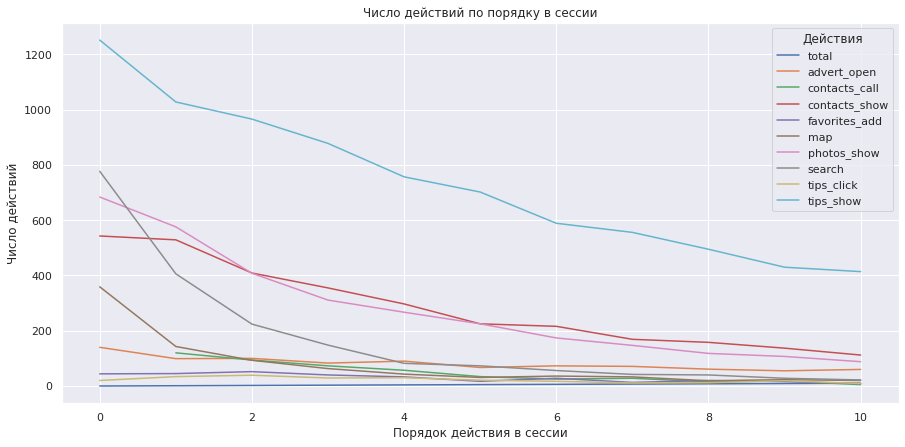

In [ ]:
event_order_pivot.plot(grid=True, figsize=(15, 7))
plt.ylabel('Число действий')
plt.xlabel('Порядок действия в сессии')
plt.legend(title='Действия')
plt.title('Число действий по порядку в сессии')
plt.show()

Чаще всего первыми действиями в сессиях являются показ рекомендаций (автоматический), поиск, просмотр фото, просмотр контактов. Вторым совершается показ фото и контактов.

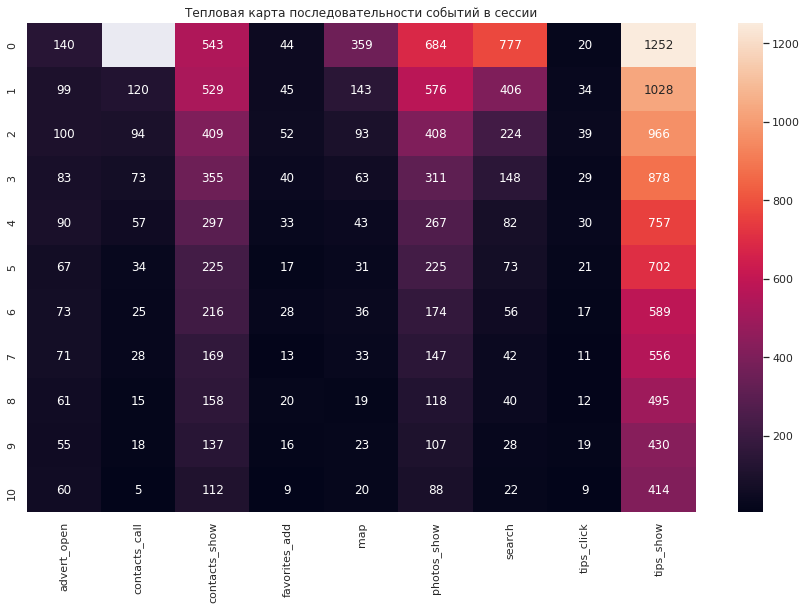

In [ ]:
plt.figure(figsize=(15, 9))  # задаём размер графика
sns.heatmap(
    event_order_pivot.drop(columns=['total']), 
    annot=True,  # включаем подписи
    fmt = '.4g'
)
plt.title('Тепловая карта последовательности событий в сессии')  # название графика
plt.show()

Опять же, самые популярные действия, сопутствующие просмотру контактов, - поиск, просмотр фото и карт. Наименее популярные - клик на рекомендованное, добавление в избранное.

#### 4.4 Промежутки времени до целевого события <a id="intervals"></a>

Рассмотрим подробнее наш датасет с данными о сессиях пользователей, когда-либо смотревших контакты.

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27197 entries, 42960 to 19052
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   session_id    27197 non-null  int64         
 1   event_time    27197 non-null  datetime64[ns]
 2   event_name    27197 non-null  object        
 3   events_order  27197 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.0+ MB


In [ ]:
filtered_df.groupby('session_id')['event_time'].nunique().describe()

count    3819.000000
mean        7.121498
std        10.062112
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max       129.000000
Name: event_time, dtype: float64

У нас всего 3819 сессий из 27197 событий, в среднем по 7 событий на сессию, самое меньшее число событий - 1, наибольшее - 129 событий в сессию. Медианное число событий - 4, и только четверть сессий насчитывает больше 8 событий.

Посмотрим, какое место в порядке действий сессии чаще всего занимает просмотр контактов .

In [ ]:
filtered_df.query('event_name == "contacts_show"')['events_order'].describe()

count    4529.000000
mean       10.136896
std        13.854375
min         0.000000
25%         2.000000
50%         5.000000
75%        13.000000
max       107.000000
Name: events_order, dtype: float64

Из 4529 просмотра контактов это действие в среднем находится нв 10 месте, медианное значение - 5, так как на среднее сильно влияют длинные сессии с числом действий более 100. В четверти случаев просмотр контактов следует вторым, а в 75% случаев занимает не выше 13 порядкового места. 

Выделим только те сессии, в которые совершался просмотр контактов, и создадим отдельный датасет с ними.

In [ ]:
contacts_show_sessions = filtered_df.query('event_name == "contacts_show"')['session_id'].unique()
contacts_show_sessions

array([    6,     8,     9, ..., 10366, 10367, 10368])

In [ ]:
contacts_show_sessions_df = filtered_df[filtered_df['session_id'].isin(contacts_show_sessions)]
contacts_show_sessions_df

session_id                 event_time     event_name  events_order
42969           6 2019-10-20 18:49:24.115634         search             0
42970           6 2019-10-20 18:59:22.541082    photos_show             1
42971           6 2019-10-20 19:03:02.030004  favorites_add             2
42972           6 2019-10-20 19:04:16.149734         search             3
42973           6 2019-10-20 19:09:56.162564         search             4
...           ...                        ...            ...           ...
19048       10368 2019-11-03 15:51:23.959572      tips_show             9
19049       10368 2019-11-03 15:51:57.899997  contacts_show            10
19050       10368 2019-11-03 16:07:40.932077      tips_show            11
19051       10368 2019-11-03 16:08:18.202734      tips_show            12
19052       10368 2019-11-03 16:08:25.388712      tips_show            13

[16812 rows x 4 columns]

In [ ]:
contacts_show_sessions_df['session_id'].nunique()

1703

Получилось 1703 сессии, в которые просматривали контакты, и в них 16812 действий. Сгруппируем по сессиям и посмотрим разницу во времени между событиями.

In [ ]:
contacts_show_sessions_df['diff'] = contacts_show_sessions_df.groupby('session_id')['event_time'].diff(1)
contacts_show_sessions_df

session_id                 event_time     event_name  events_order  \
42969           6 2019-10-20 18:49:24.115634         search             0   
42970           6 2019-10-20 18:59:22.541082    photos_show             1   
42971           6 2019-10-20 19:03:02.030004  favorites_add             2   
42972           6 2019-10-20 19:04:16.149734         search             3   
42973           6 2019-10-20 19:09:56.162564         search             4   
...           ...                        ...            ...           ...   
19048       10368 2019-11-03 15:51:23.959572      tips_show             9   
19049       10368 2019-11-03 15:51:57.899997  contacts_show            10   
19050       10368 2019-11-03 16:07:40.932077      tips_show            11   
19051       10368 2019-11-03 16:08:18.202734      tips_show            12   
19052       10368 2019-11-03 16:08:25.388712      tips_show            13   

                        diff  
42969                    NaT  
42970 0 days 00:09:58.425448  
42971 0 days 00:03:39.488922  
42972 0 days 00:01:14.119730  
42973 0 days 00:05:40.012830  
...                      ...  
19048 0 days 00:00:27.886483  
19049 0 days 00:00:33.940425  
19050 0 days 00:15:43.032080  
19051 0 days 00:00:37.270657  
19052 0 days 00:00:07.185978  

[16812 rows x 5 columns]

In [ ]:
contacts_show_sessions_df['diff'].describe()

count                        15109
mean     0 days 00:02:16.053112141
std      0 days 00:03:55.781129025
min         0 days 00:00:00.000008
25%         0 days 00:00:17.384306
50%         0 days 00:00:57.680694
75%         0 days 00:02:21.820087
max         0 days 00:29:56.515914
Name: diff, dtype: object

Средняя разница во времени в сессиях с просмотром контактов - 2 минуты 16 секунд, медианная - 57 секунд. 75% событий перемежаются промежутками, не превышающими 2,5 минуты.

Обозначим в датасете время первого события и первого просмотра контактов в сессии, а также время и название предыдущего события

In [ ]:
contacts_show_sessions_df['first_event_time'] = contacts_show_sessions_df[contacts_show_sessions_df['events_order'] == 0]['event_time']
contacts_show_sessions_df['first_contact'] = contacts_show_sessions_df[contacts_show_sessions_df['event_name'] == 'contacts_show']['event_time']
contacts_show_sessions_df['previous_time'] = contacts_show_sessions_df['event_time'].shift(+1)
contacts_show_sessions_df['previous_name'] = contacts_show_sessions_df['event_name'].shift(+1)
contacts_show_sessions_df.head()

session_id                 event_time     event_name  events_order  \
42969           6 2019-10-20 18:49:24.115634         search             0   
42970           6 2019-10-20 18:59:22.541082    photos_show             1   
42971           6 2019-10-20 19:03:02.030004  favorites_add             2   
42972           6 2019-10-20 19:04:16.149734         search             3   
42973           6 2019-10-20 19:09:56.162564         search             4   

                        diff           first_event_time first_contact  \
42969                    NaT 2019-10-20 18:49:24.115634           NaT   
42970 0 days 00:09:58.425448                        NaT           NaT   
42971 0 days 00:03:39.488922                        NaT           NaT   
42972 0 days 00:01:14.119730                        NaT           NaT   
42973 0 days 00:05:40.012830                        NaT           NaT   

                   previous_time  previous_name  
42969                        NaT            NaN  
42970 2019-10-20 18:49:24.115634         search  
42971 2019-10-20 18:59:22.541082    photos_show  
42972 2019-10-20 19:03:02.030004  favorites_add  
42973 2019-10-20 19:04:16.149734         search

У нас получилась таблица с сессиями, в которые происходили просмотры контактов, - номер сессии, названия, порядок и время всех событий, а также время первого и целевого событий + название и время действия, предшествовавшего просмотру контактов. <BR> Выделим в отдельный датасет названия и время первых действий в сессиях, а в другой - данные по целевым событиям.

In [ ]:
first_sessions = contacts_show_sessions_df.query('events_order == 0')[['session_id', 'event_name', 'first_event_time']]
first_sessions.head()

session_id     event_name           first_event_time
42969           6         search 2019-10-20 18:49:24.115634
42996           8         search 2019-10-29 21:18:24.850073
43016           9         search 2019-10-30 07:50:45.948358
43030          10  contacts_show 2019-11-03 17:12:09.708771
57261          18  contacts_show 2019-10-25 16:44:41.263364

In [ ]:
events_df = contacts_show_sessions_df.query('event_name == "contacts_show"')[['session_id', 'events_order', 'first_contact', 'previous_name', 'previous_time']]\
                                .drop_duplicates(subset=['session_id'], keep='first')
events_df.head()

session_id  events_order              first_contact  previous_name  \
42975           6             6 2019-10-20 19:17:18.659799         search   
43003           8             7 2019-10-29 21:26:40.258472    photos_show   
43024           9             8 2019-10-30 08:01:05.420773    photos_show   
43030          10             0 2019-11-03 17:12:09.708771  contacts_show   
57261          18             0 2019-10-25 16:44:41.263364  contacts_show   

                   previous_time  
42975 2019-10-20 19:11:47.344296  
43003 2019-10-29 21:26:06.398712  
43024 2019-10-30 07:59:26.486403  
43030 2019-10-30 08:26:53.933176  
57261 2019-11-03 17:12:09.708771

In [ ]:
events_df = events_df.merge(first_sessions, on='session_id')
events_df

session_id  events_order              first_contact  previous_name  \
0              6             6 2019-10-20 19:17:18.659799         search   
1              8             7 2019-10-29 21:26:40.258472    photos_show   
2              9             8 2019-10-30 08:01:05.420773    photos_show   
3             10             0 2019-11-03 17:12:09.708771  contacts_show   
4             18             0 2019-10-25 16:44:41.263364  contacts_show   
...          ...           ...                        ...            ...   
1698       10361             0 2019-10-30 00:15:43.363752  contacts_show   
1699       10365             1 2019-11-02 18:17:41.386651      tips_show   
1700       10366             1 2019-11-02 19:26:07.834494      tips_show   
1701       10367             1 2019-11-03 14:33:47.921863      tips_show   
1702       10368             5 2019-11-03 15:48:05.420247      tips_show   

                  previous_time     event_name           first_event_time  
0    2019-10-20 19:11:47.344296         search 2019-10-20 18:49:24.115634  
1    2019-10-29 21:26:06.398712         search 2019-10-29 21:18:24.850073  
2    2019-10-30 07:59:26.486403         search 2019-10-30 07:50:45.948358  
3    2019-10-30 08:26:53.933176  contacts_show 2019-11-03 17:12:09.708771  
4    2019-11-03 17:12:09.708771  contacts_show 2019-10-25 16:44:41.263364  
...                         ...            ...                        ...  
1698 2019-10-29 16:13:00.681459  contacts_show 2019-10-30 00:15:43.363752  
1699 2019-11-02 18:01:27.094834      tips_show 2019-11-02 18:01:27.094834  
1700 2019-11-02 19:25:53.794029      tips_show 2019-11-02 19:25:53.794029  
1701 2019-11-03 14:32:55.956301      tips_show 2019-11-03 14:32:55.956301  
1702 2019-11-03 15:47:43.623778      tips_show 2019-11-03 15:36:01.007440  

[1703 rows x 7 columns]

В эту таблицу добавим еще данные по временным интервалам между первым событием и первым просмотром контактов и первым просмотром контактов и предыдущим действием.

In [ ]:
events_df['interval_from_first'] = events_df['first_contact'] - events_df['first_event_time']
events_df['interval_from_previous'] = events_df['first_contact'] - events_df['previous_time']
events_df['interval_from_first'] = events_df['interval_from_first'] / np.timedelta64(1, 's')
events_df['interval_from_previous'] = events_df['interval_from_previous'] / np.timedelta64(1, 's')
events_df

session_id  events_order              first_contact  previous_name  \
0              6             6 2019-10-20 19:17:18.659799         search   
1              8             7 2019-10-29 21:26:40.258472    photos_show   
2              9             8 2019-10-30 08:01:05.420773    photos_show   
3             10             0 2019-11-03 17:12:09.708771  contacts_show   
4             18             0 2019-10-25 16:44:41.263364  contacts_show   
...          ...           ...                        ...            ...   
1698       10361             0 2019-10-30 00:15:43.363752  contacts_show   
1699       10365             1 2019-11-02 18:17:41.386651      tips_show   
1700       10366             1 2019-11-02 19:26:07.834494      tips_show   
1701       10367             1 2019-11-03 14:33:47.921863      tips_show   
1702       10368             5 2019-11-03 15:48:05.420247      tips_show   

                  previous_time     event_name           first_event_time  \
0    2019-10-20 19:11:47.344296         search 2019-10-20 18:49:24.115634   
1    2019-10-29 21:26:06.398712         search 2019-10-29 21:18:24.850073   
2    2019-10-30 07:59:26.486403         search 2019-10-30 07:50:45.948358   
3    2019-10-30 08:26:53.933176  contacts_show 2019-11-03 17:12:09.708771   
4    2019-11-03 17:12:09.708771  contacts_show 2019-10-25 16:44:41.263364   
...                         ...            ...                        ...   
1698 2019-10-29 16:13:00.681459  contacts_show 2019-10-30 00:15:43.363752   
1699 2019-11-02 18:01:27.094834      tips_show 2019-11-02 18:01:27.094834   
1700 2019-11-02 19:25:53.794029      tips_show 2019-11-02 19:25:53.794029   
1701 2019-11-03 14:32:55.956301      tips_show 2019-11-03 14:32:55.956301   
1702 2019-11-03 15:47:43.623778      tips_show 2019-11-03 15:36:01.007440   

      interval_from_first  interval_from_previous  
0             1674.544165              331.315503  
1              495.408399               33.859760  
2              619.472415               98.934370  
3                0.000000           377115.775595  
4                0.000000          -779248.445407  
...                   ...                     ...  
1698             0.000000            28962.682293  
1699           974.291817              974.291817  
1700            14.040465               14.040465  
1701            51.965562               51.965562  
1702           724.412807               21.796469  

[1703 rows x 9 columns]

У нас получились данные по 1703 сессиям. Рассмотрим их подробнее.

In [ ]:
events_df['previous_name'].value_counts()

tips_show        796
photos_show      260
contacts_show    242
search           181
contacts_call     92
map               52
advert_open       47
favorites_add     27
tips_click         6
Name: previous_name, dtype: int64

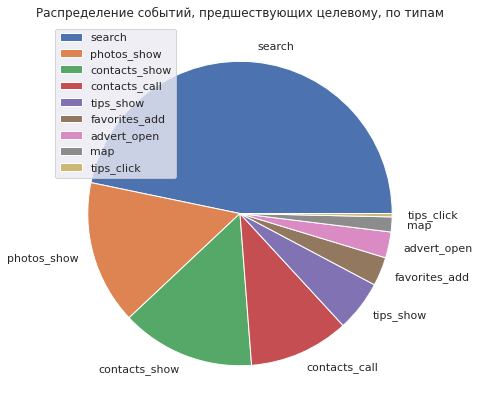

In [ ]:
fig = plt.figure(figsize =(10, 7))
plt.pie(events_df['previous_name'].value_counts(), labels=events_df['previous_name'].unique())
plt.legend(events_df['previous_name'].unique(), loc ="upper left", shadow=False)
plt.title('Распределение событий, предшествующих целевому, по типам')
plt.show()

In [ ]:
events_df['event_name'].value_counts()

contacts_show    543
tips_show        486
search           280
map              178
photos_show      156
advert_open       39
favorites_add     18
tips_click         3
Name: event_name, dtype: int64

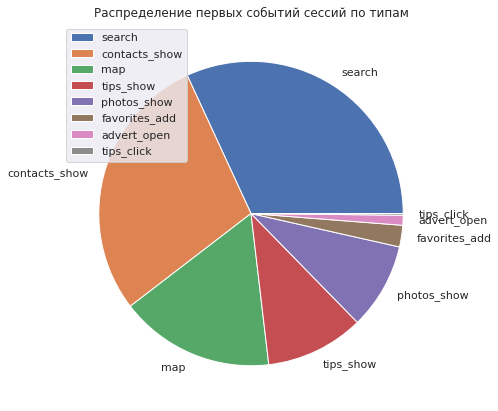

In [ ]:
fig = plt.figure(figsize =(10, 7))
plt.pie(events_df['event_name'].value_counts(), labels=events_df['event_name'].unique())
plt.legend(events_df['event_name'].unique(), loc ="upper left", shadow=False)
plt.title('Распределение первых событий сессий по типам')
plt.show()

Чаще всего просмотру контактов предшествует просмотр рекомендаций (автоматический), затем идут просмотр фото, поиск, звонок по контактам (вероятно, при повторных просмотрах контактов) и просмотр карты.

0     543
1     369
2     218
3     146
4      93
5      61
6      54
8      37
7      34
10     24
Name: events_order, dtype: int64


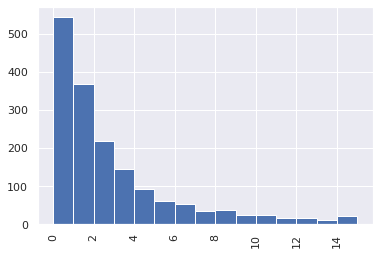

In [ ]:
print(events_df['events_order'].value_counts().head(10))
plt.hist(events_df['events_order'], bins=15, range=[0, 15])
plt.xticks(rotation='vertical')
plt.show()

Больше всего в датасете данных, конечно, по первым событиям в сессии, с каждым последующим действием их число снижается.

In [ ]:
events_df.loc[(events_df['event_name'] !='contacts_show')&(events_df['events_order'] != 0)]['interval_from_first'].describe()

count     1160.000000
mean       585.569283
std        818.461736
min          0.158918
25%         83.731705
50%        291.950202
75%        740.300075
max      12068.091077
Name: interval_from_first, dtype: float64

Среднее время между началом сессии и просмотром контактов - около 10 минут, а медианное - около 5 минут. 75% этих событий разделены не более чем 12 минутами.

In [ ]:
events_df.groupby('event_name')['interval_from_first'].mean().sort_values(ascending=False)

event_name
tips_click       1565.186135
map               637.066161
tips_show         623.283333
photos_show       607.319391
search            519.394425
favorites_add     381.123756
advert_open       287.662595
contacts_show       0.000000
Name: interval_from_first, dtype: float64

Больше всего времени для просмотра контактов проходит, если первое событие - это клик по рекомендациям. А меньше всего - если первым открывают объявление.

In [ ]:
events_df.loc[(events_df['event_name'] !='contacts_show')&(events_df['events_order'] != 0)]['interval_from_previous'].describe()

count    1160.000000
mean      167.188332
std       259.492498
min         0.158918
25%        31.539853
50%        73.045405
75%       193.103280
max      1785.300213
Name: interval_from_previous, dtype: float64

Просмотр контактов происходит в среднем через 2-3 минуты после предыдущего события, а медианный интервал - чуть больше минуты. Чаще всего переход к просмотру от предыдущего события занимает не более 3 минут.

In [ ]:
events_df.loc[(events_df['event_name'] !='contacts_show')&(events_df['events_order'] != 0)]\
         .groupby('event_name')['interval_from_previous'].mean()\
         .sort_values(ascending=False).reset_index()

event_name  interval_from_previous
0     tips_click              721.747786
1    photos_show              220.151896
2      tips_show              173.254634
3         search              158.762626
4            map              139.830181
5    advert_open               70.721185
6  favorites_add               62.574453

И в случае интервалов между предыдущим и целевым событиями наибольшие промежутки - при клике на рекомендации, но наименьший здесь - при добавлении в избранное и открытии объявления.

Как было отмечено в предыдущих выводах, самые популярные события, с которых начинаются сессии -просмотр рекомендованного и поиск, а к просмотру контактов чаще всего переходят от просмотра фото, рекомендованного, поиска и карт. От начала сессии проходит 5-12 минут до просмотра контактов, и интервал удлиняется, если сессия началась с просмотра рекомендаций. От предыдущего события требуется 1-3 минуты, чтобы перейти к просмотру контактов. Если пользователь открыл объявление или добавил его в избранное, переход к целевому действию уменьшается.

### 5. Проверка статистических гипотез <a id="hypothesis"></a>

#### 5.1 Гипотеза 1: конверсия в просмотры контактов различается у двух групп (1 группа - совершающие действия "tips_show" и "tips_click" 2 группа - только действия "tips_show") <a id="hypothesis1"></a>

Нулевая гипотеза: конверсия в просмотры контактов у двух групп (1 группа - совершающие действия "tips_show" и "tips_click" 2 группа - только действия "tips_show") одинакова

In [ ]:
tips_group = mobile_dataset[mobile_dataset['event_name'] == 'tips_show']['user_id'].unique()
print('Численность обеих групп вместе:', len(tips_group))

Численность обеих групп вместе: 2801


In [ ]:
tips_click_group = mobile_dataset[(mobile_dataset['event_name'] == 'tips_click')&(mobile_dataset['user_id'].isin(tips_group))]['user_id'].unique()
print('Численность 1 группы (с двумя событиями):', len(tips_click_group))

Численность 1 группы (с двумя событиями): 297


In [ ]:
tips_only_group = set(tips_group) - set(tips_click_group)
print('Численность 2 группы (только действие tips_show):', len(tips_only_group))

Численность 2 группы (только действие tips_show): 2504


Количество пользователей в группах сильно отличается, 297 человек в группе совершавших оба действия, и 2504 пользователя в группе только с действием "tips_show".

In [ ]:
tips_click_df = mobile_dataset[mobile_dataset['user_id'].isin(tips_click_group)]
tips_only_df = mobile_dataset[mobile_dataset['user_id'].isin(tips_only_group)]

Рассчитаем конверсию в просмотры для каждой группы: посчитаем общее количество пользователей в группах и сколько из них просматривали контакты.

In [ ]:
tips_click_conv = len(tips_click_df[tips_click_df['user_id'].isin(goal_users)]['user_id'].unique())
print('Число пользователей в группе 1, смотревших контакты:', tips_click_conv)
tips_only_conv = len(tips_only_df[tips_only_df['user_id'].isin(goal_users)]['user_id'].unique())
print('Число пользователей в группе 2, смотревших контакты:', tips_only_conv)

Число пользователей в группе 1, смотревших контакты: 91
Число пользователей в группе 2, смотревших контакты: 425


In [ ]:
print('Конверсия в группе №1', tips_click_conv/len(tips_click_group))
print('Конверсия в группе №2', tips_only_conv/len(tips_only_group))

Конверсия в группе №1 0.3063973063973064
Конверсия в группе №2 0.16972843450479233


In [ ]:
alpha = .05 # критический уровень статистической значимости

successes = (tips_click_conv, tips_only_conv)
trials = (len(tips_click_group), len(tips_only_group))

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2

In [ ]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

In [ ]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  9.218316554537864e-09
Отвергаем нулевую гипотезу: между долями есть значимая разница


P-value намного выше критического уровня статистической значимости, значит, конверсии в группах действительно различны, что подтверждают и наши вычисления.

#### 5.2 Гипотеза 2: Своя статистическая гипотеза <a id="hypothesis2"></a>

Предварительная версия: конверсия в просмотры контактов различается у двух групп (пришедших через Яндекс и пришедших через Google)

Нулевая гипотеза: конверсия в просмотры контактов у двух групп (1 группа - пришедшие через Яндекс 2 группа - пришедшие через Google) одинакова

In [ ]:
yandex_group = mobile_dataset[mobile_dataset['source'] == 'yandex']
print('Численность группы пользователей из Яндекс:', len(yandex_group['user_id'].unique()))

Численность группы пользователей из Яндекс: 1934


In [ ]:
google_group = mobile_dataset[mobile_dataset['source'] == 'google']
print('Численность группы пользователей из Google:', len(google_group['user_id'].unique()))

Численность группы пользователей из Google: 1129


In [ ]:
yandex_group_conv = yandex_group[yandex_group['user_id'].isin(goal_users)]
print('Число пользователей в группе 1, смотревших контакты:', len(yandex_group_conv['user_id'].unique()))
google_group_conv = google_group[google_group['user_id'].isin(goal_users)]
print('Число пользователей в группе 2, смотревших контакты:', len(google_group_conv['user_id'].unique()))

Число пользователей в группе 1, смотревших контакты: 478
Число пользователей в группе 2, смотревших контакты: 275


In [ ]:
print('Конверсия в группе №1 (Yandex):', len(yandex_group_conv['user_id'].unique())/len(yandex_group['user_id'].unique()))
print('Конверсия в группе №2 (Google):', len(google_group_conv['user_id'].unique())/len(google_group['user_id'].unique()))

Конверсия в группе №1 (Yandex): 0.24715615305067218
Конверсия в группе №2 (Google): 0.24357838795394154


In [ ]:
alpha = .05 # критический уровень статистической значимости

successes = (len(yandex_group_conv['user_id'].unique()), len(google_group_conv['user_id'].unique()))
trials = (len(yandex_group['user_id'].unique()), len(google_group['user_id'].unique()))

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2

In [ ]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

In [ ]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Мы не нашли значительной статистической разницы между долями обеих групп, значит, источник пользователя не оказывает особого влияния на конверсию, как и показали наши подсчеты выше.

Согласно проверке наших гипотез, на конверсию не оказывает большого влияния источник, откуда пришел пользователь. Но последовательность его действий влияет на склонность к просмотру контактов. Это подтверждает и рассчитанная нами конверсия.

### 6. Вывод <a id="conclusion"></a>

- Для исследования были взяты данные о событиях при использовании пользователями приложения - со временем события, его названием, айди и источником появления пользователя.
- Данные были представлены за период в 28 дней - с 7 октября по 3 ноября 2019 года.
- Датасет содержит данные по 74197 событиям и 4293 пользователям.
- В процессе обработки данных я разделила логи событий на сессии на основании интервала между событиями (если между последовательными событиями одного пользователя проходило более 30 минут - следующее событие считалось началом новой сессии). Получилось 10368 сессий, в среднем по 2,5 сессии на пользователя и по 1,5-2 события на сессию.
- Среднее время сессии - 1-2 минуты, и только четверть сессий превышает длительностью 2,5 минуты.
- Целевое событие - просмотр контактов в объявлении - совершил 981 пользователь 4529 раз.

- Затем я выделила в отдельный датасет с данными по всем событиям пользователей, когда-либо совершавшим целевое действие - получилось 27197 событий и 3819 сессий, в среднем по 7 событий на сессию, самое меньшее число событий - 1, наибольшее - 129 событий в сессию. Медианное число событий - 4, и только четверть сессий насчитывает больше 8 событий.
- В среднем на каждого пользователя, совершившего целевое действие, приходится 27 событий (против 17 по датасету в целом) и почти 4 сессии (против 2,5). 
- Значит, пользователи, просматривающие контакты, активнее пользуются приложением, у них больше сессий, и эти сессии продолжительнее и содержательнее.
- Самые популярные события для "целевых" юзеров - просмотр фото, поиск, открытие объявления. Они чуть чаще смотрят фото, чем пользователи в целом.
- В целом по данным популярны те же события, просмотров фото случается примерно по 10 на пользователя, поисков - по 4-5, юзеры открывают контакты по 4-5 раз.
- Я также разделила пользователей на когорты в зависимости от недели их прихода в приложение - получилось 4 когорты численностью 900-1100 человек.

- У нас три источника прихода юзера - Яндекс, Гугл и органический трафик. Почти половина пользователей (как в целом по датасету, так и только среди "целевых") пришли через Яндекс, около 30% - через Гугл, оставшиеся 22-26% пришли сами. Источник появления пользователя в приложении не сильно влияет на конверсию, что мы подтвердили проверкой гипотезы и расчетом самой конверсии (24%).
- Также заметны проседания как в активности, так и в конверсии в просмотры в конце выходных (особенно, воскресенье-понедельник) и подъемы в середине недели (черверг-пятница).
- Что касается конверсии в просмотры в разрезе уникальных пользователей, то она высока у добавлений в избранное -почти 39%, что видно и по воронке, а также у кликов по рекомендациям - 31%. Конверсия просмотра фото - тоже почти 31%. Конверсия по числу событий при переходе от клика по рекомендации к просмотру контактов составляет целых 41%, у просмотра фото - 38%.
- Количество активных пользователей в день составляет 279, в неделю - 1382.
- Коэффициент удержания для приложения не сильно высокий, и к концу исследуемого периода заметно его снижение (возможно, временное). 

- Первым действием в сессии, помимо рекомендаций, чаще всего является поиск или просмотр фото, просмотр контактов тоже чаще совершается в первой тройке событий сессии.
- В сессиях, в которых совершали целевое действие, разница во времени между событиями составляет 1-2 минуты, чаще всего первым событием в такой сессии являются просмотр рекомендации, просмотр фото, поиск, просмотр карты. Самому целевому событию также предшествуют показ рекомендаций, фото, поиск, просмотр карт.
- Среднее время между началом сессии и целевым действием составляет около 10 минут, медианное - 5 минут. В 75% сессий для перехода к просмотру контактов нужно не более 12 минут.
- Если первым действием сессии является просмотр рекомендации или клик по рекомендации, промежуток до просмотра контактов будет дольше, чем при открытии сессии добавлением в избранное, открытием объявления или поиском. Переход к просмотру контактов от предыдущего объявления занимает 2-3 минуты, что удлиняется до 10 минут при клике на рекомендацию, а после открытия объявления или добавления в избранное составляет всего минуту. 

- Особенностью конверсии в просмотры являются высокая эффективность специфичных и малораспространенных действий (добавление в избранное, клик по рекомендации), после которых пользователь в большинстве случаев перейдет к целевому, и малая эффективность сильно распространенных событий, в частности, автоматических рекомендаций. Конверсия от автоматической рекомендации к переходу на него крайне низкая, возможно, если попытаться улучшить качество рекомендаций, получится увеличить и конверсию в просмотры контактов. 
- Стоит обратить внимание на привлечение и удержание пользователей, возможно, применить какие-либо акции или рекламу. 